In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
import numpy as np
import pickle
from keras.models import Sequential
from keras.layers import Embedding, Dropout, LSTM, GlobalMaxPooling1D, Dense, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# NLTK için durdurma kelimeleri ve lemmatizer'i indir
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Durdurma kelimeleri ve lemmatizer
stop_words = set(stopwords.words('turkish'))
lemmatizer = WordNetLemmatizer()

# CSV dosyasını yükleyin ve verileri ayırın
data = pd.read_csv("e-ticaret_urun_yorumlari.csv", encoding="utf-8-sig", sep=";", engine="python", on_bad_lines="skip")

# DataFrame'in ilk birkaç satırını görüntüleme
print(data.head())

# Eğer veriler tek bir sütunda ise, 'Metin' ve 'Durum' sütunlarını ayırın
if 'Metin;Durum' in data.columns:
    data[['Metin', 'Durum']] = data['Metin;Durum'].str.split(';', expand=True)

# Sütun isimlerini düzeltme
data.columns = ['Metin', 'Durum']

# Metinleri ön işleme
data['Metin'] = data['Metin'].fillna('')  # Boş olanları boş string ile doldur

# Etiketleri sayısal hale getirme
label_encoder = LabelEncoder()
data['durum_encoded'] = label_encoder.fit_transform(data['Durum'])
y = data['durum_encoded'].values

# Veri ön işleme
preprocessed_data = []
for text in data['Metin']:
    text = text.lower()
    words = word_tokenize(text)  # Tokenize işlemi
    filtered_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and word.isalpha()]  # Stopwords ve özel karakterleri çıkar
    preprocessed_data.append(filtered_words)

# Word2Vec modelini eğitme
embedding_dim = 300  # Daha yüksek bir boyut veriye göre daha iyi olabilir
word2vec_model = Word2Vec(sentences=preprocessed_data, vector_size=embedding_dim, window=5, min_count=1, workers=4)

# Kelime sıraları ve dizinleri oluşturma
word_index = {word: index + 1 for index, word in enumerate(word2vec_model.wv.index_to_key)}

# Veriyi sayısal diziye çevirme ve hizalama
max_length = 100  # Daha yüksek max_length metinlerin daha kapsamlı temsilini sağlar
train_sequences_word2vec = [[word_index[word] for word in text if word in word_index] for text in preprocessed_data]
X = pad_sequences(train_sequences_word2vec, maxlen=max_length, padding='post', truncating='post')

# Word2Vec gömme matrisi oluşturma
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = word2vec_model.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Tokenizer'ı pickle ile kaydetme
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(word_index, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Modeli güncellenmiş hali ile oluşturma
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_length,
                    trainable=True))  # Embedding katmanını güncellemeye açık hale getirdik
model.add(Dropout(0.5))  # Overfitting'i azaltmak için Dropout ekledik
model.add(LSTM(128, return_sequences=True))  # LSTM ile dilin daha karmaşık ilişkilerini öğrenmesini sağladık
model.add(GlobalMaxPooling1D())  # Önemli özellikleri çıkarmak için Global Max Pooling
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())  # Normalizasyon ekledik
model.add(Dropout(0.5))  # Bir diğer Dropout katmanı
model.add(Dense(3, activation='softmax'))  # 3 sınıf için softmax

# Optimizasyon ayarlarıyla model derleme
optimizer = Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Early stopping eklenmesi
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Modeli eğitme
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Modeli değerlendirme
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                               Metin  Durum
0                              evet anlatıldığı gibi      1
1  Daha öncede almıştım bu cihazdan ense ve sakal...      1
2  Ürün gayet başarılı sakal kesmede başlık sayıs...      1
3  Daha öncede aynısını almıştım çok güzel ve kal...      1
4  Erkek kuaförüyüm ense ve sıfır sakal traşı içi...      1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
380/380 ━━━━━━━━━━━━━━━━━━━━ 118s 304ms/step - accuracy: 0.6184 - loss: 0.8993 - val_accuracy: 0.6968 - val_loss: 0.7770
Epoch 2/5
380/380 ━━━━━━━━━━━━━━━━━━━━ 141s 302ms/step - accuracy: 0.8695 - loss: 0.3464 - val_accuracy: 0.8682 - val_loss: 0.3516
Epoch 3/5
380/380 ━━━━━━━━━━━━━━━━━━━━ 119s 314ms/step - accuracy: 0.9250 - loss: 0.1986 - val_accuracy: 0.8649 - val_loss: 0.6109
Epoch 4/5
380/380 ━━━━━━━━━━━━━━━━━━━━ 139s 307ms/step - accuracy: 0.9592 - loss: 0.1305 - val_accuracy: 0.8652 - val_loss: 0.4923
Epoch 5/5
380/380 ━━━━━━━━━━━━━━━━━━━━ 148s 322ms/step - accuracy: 0.9708 - loss: 0.0944 - val_accuracy: 0.8767 - val_loss: 0.4645
95/95 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.8815 - loss: 0.3220
Accuracy: 86.82%


In [ ]:
from tensorflow.keras.models import load_model
# Modeli eğitirken LabelEncoder'ı kaydedin
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # y_train verinizi kullanarak etiketleri encode edin

# LabelEncoder'ı pickle ile kaydedin
with open('label_encoder.pickle', 'wb') as le_handle:
    pickle.dump(label_encoder, le_handle)
print("LabelEncoder başarıyla kaydedildi.")

# Eğitilmiş modeli kaydetme
model.save('my_model1.keras')
print("Eğitilmiş model başarıyla kaydedildi.")

# Modeli yükleme
model = load_model('my_model1.keras')
print("Model başarıyla kaydedildi.")

LabelEncoder başarıyla kaydedildi.
Eğitilmiş model başarıyla kaydedildi.
Model başarıyla kaydedildi.


In [ ]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

# Yeni bir yorum üzerinde tahmin yapmak
new_text = ["hiç beğenmedim"]
new_sequences = [[word_index[word] for word in text_to_word_sequence(text.lower()) if word in word_index] for text in new_text]
new_padded = pad_sequences(new_sequences, maxlen=max_length, padding='post', truncating='post')

# Tahmini yap
predictions = model.predict(new_padded)
predicted_class_index = predictions.argmax(axis=-1)[0]
predicted_class = label_encoder.inverse_transform([predicted_class_index])[0]

print(f"The predicted class for the new input is: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
The predicted class for the new input is: 0


95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step


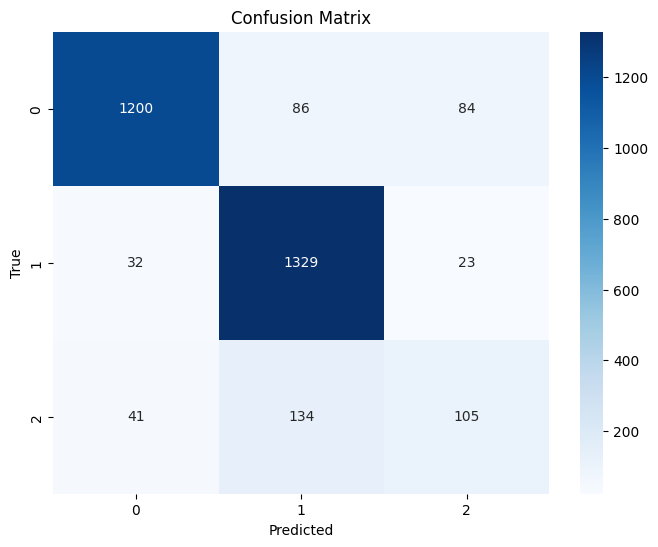

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.88      0.91      1370
           1       0.86      0.96      0.91      1384
           2       0.50      0.38      0.43       280

    accuracy                           0.87      3034
   macro avg       0.77      0.74      0.75      3034
weighted avg       0.86      0.87      0.86      3034



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tahminleri hesaplama
y_pred = model.predict(X_test)

# Tahminleri ve gerçek etiketleri sınıf isimlerine dönüştürme
y_pred_labels = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))
y_true_labels = label_encoder.inverse_transform(y_test)

# Karışıklık matrisi
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=label_encoder.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Sınıflandırma raporu
print("Classification Report:\n", classification_report(y_true_labels, y_pred_labels))

# Modeli kaydetme
model.save("my_model1.keras")
# Modeli yükleme (isteğe bağlı)
loaded_model = load_model("my_model1.keras")

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


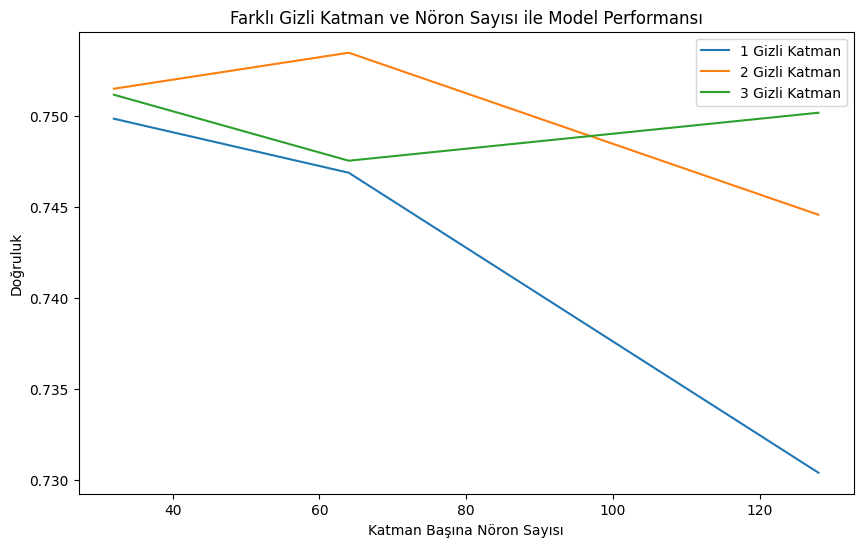

In [ ]:
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Fonksiyon: model yaratma ve derleme
def create_model(hidden_layers, neurons_per_layer):
    model = Sequential()
    model.add(Embedding(input_dim=len(word_index) + 1,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_length,
                        trainable=False))
    model.add(Flatten())

    for _ in range(hidden_layers):
        model.add(Dense(neurons_per_layer, activation='relu'))

    model.add(Dense(3, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Sonuçları saklamak için listeler
hidden_layers_list = [1, 2, 3]
neurons_per_layer_list = [32, 64, 128]
accuracy_results = []

# Eğitim ve değerlendirme: farklı konfigürasyonlarda model performansını test etme
for hidden_layers in hidden_layers_list:
    for neurons_per_layer in neurons_per_layer_list:
        model = create_model(hidden_layers, neurons_per_layer)
        model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=0)

        # Tahminler ve doğruluk hesaplama
        y_pred = model.predict(X_test)
        y_pred_labels = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))
        y_true_labels = label_encoder.inverse_transform(y_test)
        accuracy = accuracy_score(y_true_labels, y_pred_labels)

        # Sonuçları listeye ekleme
        accuracy_results.append((hidden_layers, neurons_per_layer, accuracy))

# Grafiği oluşturma
fig, ax = plt.subplots(figsize=(10, 6))

for hidden_layers in hidden_layers_list:
    data = [result[2] for result in accuracy_results if result[0] == hidden_layers]
    ax.plot(neurons_per_layer_list, data, label=f'{hidden_layers} Gizli Katman')

ax.set_xlabel('Katman Başına Nöron Sayısı')
ax.set_ylabel('Doğruluk')
ax.set_title('Farklı Gizli Katman ve Nöron Sayısı ile Model Performansı')
ax.legend()
plt.show()

Epoch 1/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.7730 - loss: 0.5409 - val_accuracy: 0.7291 - val_loss: 0.6921
Epoch 2/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.7709 - loss: 0.5540 - val_accuracy: 0.7357 - val_loss: 0.6961
Epoch 3/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.7906 - loss: 0.5090 - val_accuracy: 0.7535 - val_loss: 0.6690
Epoch 4/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.7934 - loss: 0.5073 - val_accuracy: 0.7495 - val_loss: 0.6721
Epoch 5/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 42s 64ms/step - accuracy: 0.7961 - loss: 0.4928 - val_accuracy: 0.7521 - val_loss: 0.7351
Epoch 6/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 40s 61ms/step - accuracy: 0.7939 - loss: 0.4992 - val_accuracy: 0.7406 - val_loss: 0.6977
Epoch 7/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.8109 - loss: 0.4718 - val_accuracy: 0.7508 - val_loss: 0.7227
Epoch 8/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.8097 - loss: 0.4663 - 

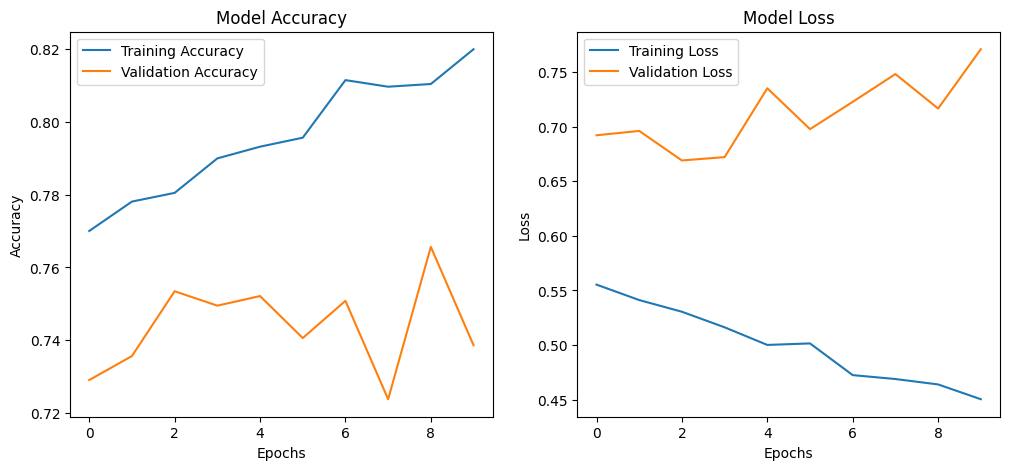

In [ ]:
# Modeli eğitme ve eğitim geçmişini toplama
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Eğitim ve doğrulama doğruluğunu epoch'lara göre çizdirme
plt.figure(figsize=(12, 5))

# Eğitim ve doğrulama doğruluğunu çizdirme
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Eğitim ve doğrulama kaybını çizdirme
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
import pandas as pd
import re

# Dosyayı yükleme
df = pd.read_csv("youtube_comments.csv")

# Ön işleme fonksiyonu tanımlama
def preprocess_comment(comment):
    # İstenmeyen ifadeleri temizleme
    comment = re.sub(r'\bYanıtla\b', '', comment, flags=re.IGNORECASE)  # 'Yanıtla' kelimesini kaldır
    comment = re.sub(r'\bdevamını oku\b', '', comment, flags=re.IGNORECASE)  # 'devamını oku' ifadesini kaldır
    comment = re.sub(r'\b\d+[,.]?\d*\b', '', comment)  # Sayıları kaldır
    comment = re.sub(r'\b\d+ yıl önce\b', '', comment, flags=re.IGNORECASE)  # 'yıl önce' ifadelerini kaldır
    comment = re.sub(r'@\w+', '', comment)  # '@' ile başlayan kullanıcı adlarını kaldır
    comment = re.sub(r'\(düzenlendi\)', '', comment, flags=re.IGNORECASE)  # '(düzenlendi)' ifadesini kaldır
    comment = re.sub(r'\bB\b', '', comment)  # 'B' harfini kaldır
    comment = re.sub(r'\byanıt\b', '', comment, flags=re.IGNORECASE)  # 'yanıt' kelimesini kaldır


    return comment

# Yorumları ön işleme tabi tutma
df['Comment'] = df['Comment'].apply(preprocess_comment)

# İşlenmiş veriyi yeni bir CSV dosyasına kaydetme
df.to_csv("youtube_comments_with_sentiment.csv", index=False)
print("Sonuçlar youtube_comments_with_sentiment.csv dosyasına kaydedildi.")

Sonuçlar youtube_comments_with_sentiment.csv dosyasına kaydedildi.


In [ ]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 11.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
from unidecode import unidecode

# Yorumları işlemek için fonksiyon
def preprocess_text(text):
    # Küçük harfe çevirme
    text = text.lower()

    # Türkçe karakterleri ASCII'ye çevirme
    text = unidecode(text)

    # İstenmeyen ifadeleri kaldırma
    text = re.sub(r'\byil once\b', '', text)  # "yil once" ifadesini kaldırma

    # Tırnak işaretlerini kaldırma (hem çift hem tek tırnak)
    text = text.replace('"', '').replace("'", '')

    # Sadece harf, boşluk ve sayılara izin verme
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Tek harfli kelimeleri kaldırma
    text = ' '.join([word for word in text.split() if len(word) > 1])

    # Fazla boşlukları kaldırma
    text = ' '.join(text.split())

    return text

# 1. youtube_comments.csv dosyasını yükleyelim
df = pd.read_csv('youtube_comments_with_sentiment.csv')

# 2. Yorumları tek bir satırdan ayıralım
comments_string = df.iloc[0, 0]  # Tek satırdaki tüm yorumları alıyoruz

# Yorumları ayırmak için '\n' ayırıcıyı kullanalım ve `""` olan satırları filtreleyelim
comments_list = [
    comment for comment in re.split(r'\n', comments_string)
    if comment.strip() and comment.strip() != '""'
]

# 3. Yorumları ön işleme tabi tutalım
comments_list = [preprocess_text(comment) for comment in comments_list if comment.strip() != ""]  # Boş yorumları kaldırıyoruz

# 4. Yorumları predicted_comments.csv dosyasına kaydedelim
result_df = pd.DataFrame({'Comment': comments_list})

# 5. Dosyayı kaydedelim
result_df.to_csv('predicted_comments.csv', index=False)

# 6. İlk birkaç sonucu ekrana yazdıralım
print(result_df.head())


                                             Comment
0                  haluk tatar tarafindan sabitlendi
1                                             vesiir
2                                                   
3                                    henuz baslayali
4  hafta oldu ama dinlegim yabanci sarkilar olsun...


In [ ]:
#//////3333333
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Modeli ve tokenizer'ı yükleyin
loaded_model = load_model('my_model1.keras')  # Kendi model dosyanızın yolunu verin
tokenizer = Tokenizer()  # Eğer daha önce kaydedilen tokenizer'ı kullanıyorsanız, onu yükleyin

# 1. Eğitim verilerinizi kullanarak LabelEncoder'ı fit edin (önceden kaydedilmemişse)
# Burada, modelin eğitildiği etiketler (y_train veya y_test) ile fit işlemi yapılması gerekiyor
# Bu örnekte 'durumlar' adında etiketlerinizi içeren bir liste oluşturduğumuzu varsayıyorum
durumlar = ['0', '1', '2']  # Modelinize uygun olan etiketleri kullanın
le = LabelEncoder()
le.fit(durumlar)  # Etiketlerinizi fit ettik

# 2. Ön işlenmiş yorumları içeren CSV dosyasını yükleyin
df = pd.read_csv('predicted_comments.csv')

# 3. Yorumları listeye çevirin ve boş değerleri (NaN) temizleyin
comments_list = df['Comment'].dropna().tolist()  # NaN değerleri temizleriz

# 4. Yorumları sayılara dönüştürme ve padding işlemi
X_new_seq = tokenizer.texts_to_sequences(comments_list)
X_new_padded = pad_sequences(X_new_seq, maxlen=100)  # padding uzunluğunu kendi modelinize göre ayarlayın

# 5. Modeli kullanarak tahmin yapın
predictions = loaded_model.predict(X_new_padded)

# 6. Tahminleri etiketlere dönüştürme
predicted_labels = le.inverse_transform(predictions.argmax(axis=1))  # inverse_transform kullanımı burada

# 7. Tahmin sonuçlarıyla yeni bir DataFrame oluşturun
result_df = pd.DataFrame({
    'Metin': comments_list,
    'Durum': predicted_labels
})

# 8. Yeni CSV dosyasına kaydedin
result_df.to_csv('predicted_comments_15_update.csv', index=False, sep=';')

# 9. İlk birkaç satırı ekrana yazdırarak kontrol edebilirsiniz
print(result_df.head())


31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step
                                               Metin Durum
0                  haluk tatar tarafindan sabitlendi     0
1                                             vesiir     0
2                                    henuz baslayali     0
3  hafta oldu ama dinlegim yabanci sarkilar olsun...     0
4  birseyleri ogrenmek insana cok iyi geliyor eme...     0


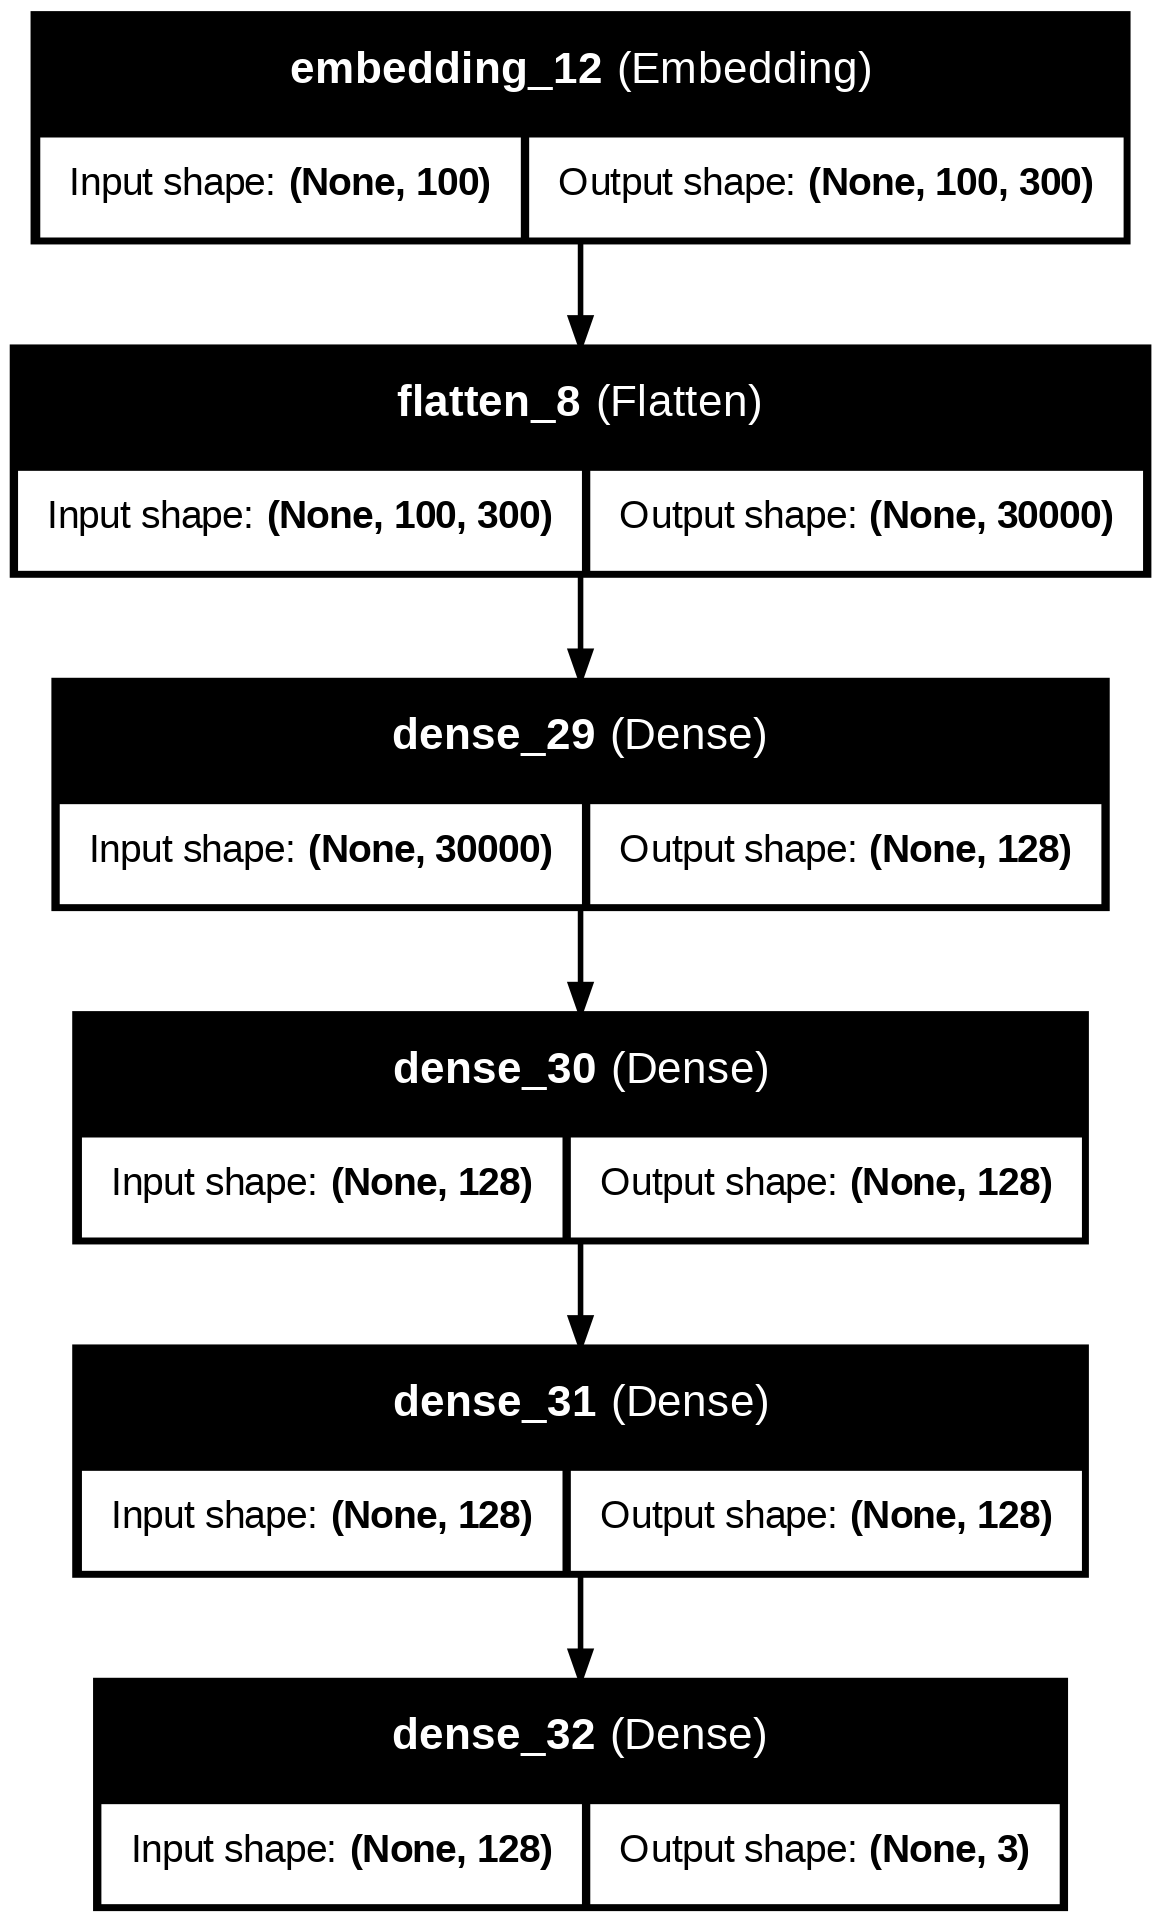

In [ ]:
#Yapay Sinir Ağlarını görüntüleme
from tensorflow.keras.utils import plot_model
# Model mimarisini dosyaya kaydetmek
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)